In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[1:], mse_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mse_validation[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [4]:
l_min = 1
l_max = 1

n_l = 1  # defined only one value for L, for now.

# q in kN
q_min = 100
q_max = 1000

n_q = 10

# E in GPa
E_min = 210
E_max = 300

n_E = 10

# I in cm^4
I_min = 1 * 10 ** (3) 
I_max = 10 * 10 ** (3)

n_I = 10

# Will make the vectors linearly spaced, but it's not necessary
l_vec = np.linspace(l_min, l_max, n_l)
q_vec = np.linspace(q_min, q_max, n_q)
E_vec = np.linspace(E_min, E_max, n_E)
I_vec = np.linspace(I_min, I_max, n_I)

In [5]:
# Compute all possible permutations and arrange them in a matrix

per_list = []
for i in range(len(l_vec)):
    for j in range(len(q_vec)):
        for k in range(len(E_vec)):
            for l in range(len(I_vec)):
                per_list = np.append(per_list, np.array([[l_vec[i], q_vec[j], E_vec[k], I_vec[l]]]))

per_list = per_list.reshape(-1, 4)

# Shuffle the permutations
np.random.shuffle(per_list)

np.save('125_combinations', per_list)  # saved as an .npy file to use later using np.load('125_combinations')

In [6]:
# analytical solution for the beam bending problem

def ana_sol(n, l, q, E, I):
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x

    return [x, y]

def ana_sol_with_noise(n, param_list,noise):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x
    y = y + noise * (np.random.random(len(y)) - 0.5) * (np.max(y) - np.min(y))

    return [x, y]

In [7]:
#alternative way to generate fake data with noise
n = 1000
# Add noise
noise_factor = 0.2
#create dictionary with generated data
fake_data = {}
#dict keys: list of parameters values
#dict values: (x,y) array 
for i in per_list:
    fake_data[repr(i.tolist())] = ana_sol_with_noise(n, i, noise_factor)

In [8]:
#for each entry combination of (l,q,E,I) we have two columns of fake data: both x and noisy y 
fake_dataframe=pd.DataFrame.from_dict(fake_data,orient='index',columns=['x', 'y'])
#I will now dstructure the data in such a way that we are able to immediatly assess 
# which entry combination of (l,q,E,I) gives a specific (x,Y)
#let's clean a little
fake_dataframe=fake_dataframe.rename_axis('parameters').reset_index()
fake_dataframe.parameters=[eval(fake_dataframe.parameters[i]) for i in range(len(fake_dataframe))]
fake_dataframe[['l','q','E','I']] = pd.DataFrame(fake_dataframe.parameters.tolist(), index= fake_dataframe.index)
fake_dataframe=fake_dataframe.drop(columns='parameters')
#let's see an example of structured data
fake_dataframe

,x,y,l,q,E,I
0,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.00013189396541500646, -5.9411802677386266e-...",1.0,500.0,290.0,1000.0
1,"[0.0, 0.001001001001001001, 0.0020020020020020...","[8.19643094453805e-06, -6.689340110456274e-06,...",1.0,300.0,270.0,9000.0
2,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-1.8289954964505114e-05, 2.3297927017285903e-...",1.0,400.0,300.0,7000.0
3,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-5.209178407618828e-06, -8.2038410330914e-06,...",1.0,200.0,220.0,8000.0
4,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-1.1914606048802612e-05, -5.044492792873286e-...",1.0,700.0,240.0,9000.0
...,...,...,...,...,...,...
995,"[0.0, 0.001001001001001001, 0.0020020020020020...","[3.3232651142468154e-05, -1.6382932811589727e-...",1.0,1000.0,270.0,9000.0
996,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-5.416743892636422e-05, -1.6604213650810908e-...",1.0,400.0,270.0,3000.0
997,"[0.0, 0.001001001001001001, 0.0020020020020020...","[1.132082356275916e-05, -9.721635814213549e-06...",1.0,400.0,250.0,8000.0
998,"[0.0, 0.001001001001001001, 0.0020020020020020...","[6.622738147318052e-05, 8.780321251509569e-05,...",1.0,400.0,280.0,2000.0


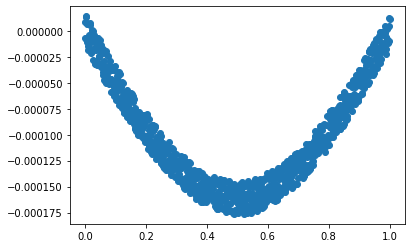

In [9]:
#plot the 1st entry of the dataframe
plt.scatter(fake_dataframe['x'][1],fake_dataframe['y'][1],label=str(fake_dataframe.index[1]))
plt.show()

In [10]:
#with the dataset organized is much easier to split the data.
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
#let's take a look at an example 
test_split=0.1 #we will use 10% of the data for testing. 
df = fake_dataframe
train_df, test_df = train_test_split(df, test_size = test_split)

In [11]:
#the training data will be spllited automatically by 80/20 during training using keras framework. 
# no need to split at this stage.
#let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (900, 6)
Test set:  (100, 6)


C:\Users\luisf\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


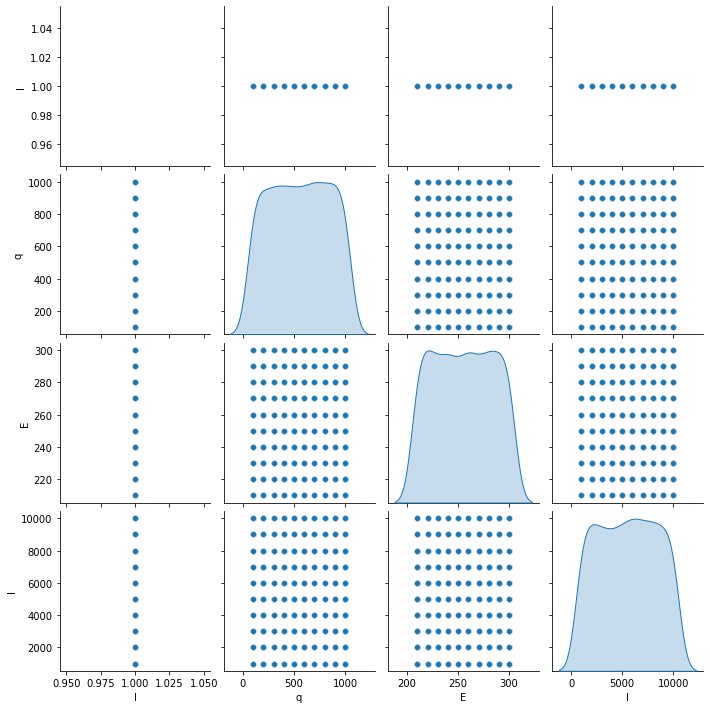

In [12]:
#inspect the training dataset
sns.pairplot(train_df[['l', 'q', 'E', 'I']], diag_kind='kde')

In [13]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
l,900.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
q,900.0,552.111111,287.147741,100.0,300.0,600.0,800.0,1000.0
E,900.0,254.877778,28.950623,210.0,230.0,260.0,280.0,300.0
I,900.0,5492.222222,2859.899878,1000.0,3000.0,6000.0,8000.0,10000.0


In [14]:
# follow this tutorial for our data 
# https://www.tensorflow.org/tutorials/keras/regression
# whenever possible, add comments and discussion

In [15]:
# get the max "y" for each entry
df.y.apply(min)
# at this point we could plot very interesting stuff such as ymax distributions on the vars (q,l,E,I)...
# but let's think about that later

0     -0.002461
1     -0.000176
2     -0.000272
3     -0.000162
4     -0.000462
         ...   
995   -0.000587
996   -0.000706
997   -0.000285
998   -0.001020
999   -0.000153
Name: y, Length: 1000, dtype: float64

In [16]:
# I have fixed the value of L as 1.0 for now, so I am not using the values of [x,y] as inputs, only the values of y.

In [17]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

# train_labels = pd.DataFrame([train_features.pop('l'), train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
# train_labels = train_labels.T
# test_labels = pd.DataFrame([test_features.pop('l'), test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
# test_labels = test_labels.T

train_labels = pd.DataFrame([train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
test_labels = test_labels.T

In [18]:
# I'm not yet sure what would be the correct way to normalize the values of y, as they are in the shape of vectors.

In [19]:
feature_columns = []

# Will not include the values of x
# x_col = tf.feature_column.numeric_column("x")
# feature_columns.append(x_col)
y_col = tf.feature_column.numeric_column("y")
feature_columns.append(y_col)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [20]:
# Build the model and define its architecture.

In [21]:
inputs = keras.Input(shape=(n))

In [22]:
dense = layers.Dense(256, activation="relu")
x = dense(inputs)

In [23]:
dense = layers.Dense(128, activation="relu")
x = dense(x)

dense = layers.Dense(64, activation="relu")
x = dense(x)

dense = layers.Dense(32, activation="relu")
x = dense(x)

dense = layers.Dense(16, activation="relu")
x = dense(x)

In [24]:
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(3)(x)

In [25]:
model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272   

In [27]:
# Set the hyperparameters

validation_split=0.2
learning_rate = 0.01
batch_size = 80
epochs = 25

In [28]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

# Still need to find what's the best loss function for our model.

In [29]:
# For some reason I had to manually convert the data into tensors.

tf_train_features = tf.constant([train_features['y']], shape=(train_size,n))

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,3))

tf_test_features = tf.constant([test_features['y']], shape=(test_size,n))

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,3))

In [30]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/25
9/9 [==============================] - 1s 31ms/step - loss: 13023280.0000 - val_loss: 12414805.0000
Epoch 2/25
9/9 [==============================] - 0s 11ms/step - loss: 12265243.0000 - val_loss: 9681086.0000
Epoch 3/25
9/9 [==============================] - 0s 10ms/step - loss: 7559351.5000 - val_loss: 6336356.5000
Epoch 4/25
9/9 [==============================] - 0s 7ms/step - loss: 4950076.5000 - val_loss: 3672879.2500
Epoch 5/25
9/9 [==============================] - 0s 10ms/step - loss: 3165762.5000 - val_loss: 2579666.5000
Epoch 6/25
9/9 [==============================] - 0s 10ms/step - loss: 2328240.5000 - val_loss: 1884295.5000
Epoch 7/25
9/9 [==============================] - 0s 9ms/step - loss: 1954085.1250 - val_loss: 1307984.6250
Epoch 8/25
9/9 [==============================] - 0s 10ms/step - loss: 1625024.5000 - val_loss: 1326876.6250
Epoch 9/25
9/9 [==============================] - 0s 9ms/step - loss: 1539662.3750 - val_loss: 1206425.8750
Epoch 10/25
9/9 [==

11094715.25


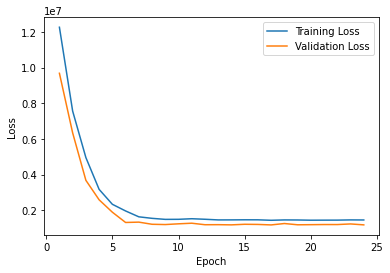

In [31]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [38]:
tf_test_labels[0:10]

<tf.Tensor: shape=(10, 3), dtype=float64, numpy=
array([[ 200.,  260., 6000.],
       [ 600.,  300., 1000.],
       [ 200.,  230., 8000.],
       [ 900.,  270., 9000.],
       [1000.,  250., 1000.],
       [ 500.,  280., 2000.],
       [ 500.,  300., 3000.],
       [1000.,  240., 4000.],
       [ 700.,  230., 5000.],
       [ 600.,  280., 8000.]])>

In [39]:
model.predict(tf_test_features)[0:10]

array([[ 596.01855 ,  315.66315 , 7616.221   ],
       [ 116.53331 ,   62.01381 , 1484.1176  ],
       [ 604.54834 ,  320.17615 , 7725.299   ],
       [ 491.21564 ,  260.21313 , 6276.017   ],
       [ 101.7347  ,   54.181065, 1294.8856  ],
       [ 267.27808 ,  141.73055 , 3412.335   ],
       [ 411.79636 ,  218.1934  , 5260.414   ],
       [ 216.74922 ,  114.99669 , 2766.144   ],
       [ 388.89642 ,  206.07735 , 4967.5737  ],
       [ 536.0404  ,  283.92938 , 6849.2285  ]], dtype=float32)

In [34]:
# 07/08/2021

# There is no point in trying to guess L in this case, as there is only one value for it.

# Even for multiple values of L, I think that it doesn't make sense to have [x, y] as inputs and at the same time try to 
# guess L, at least in the way I was innitially doing, because, (as the x values are linnearly spaced and allways the same
# for each L), we could easily check the max value of x and get L from that, without any need for a machine learning method.

In [35]:
# 07/08/2021

# Need to improve the way I feed the data to the model (had to extract it from DataFrames and convert the arrays to tensors...)

# Will try to figure out the best loss function, the best architecture for the model,
# tune the hyperparameters and try to get good results.

In [36]:
# 12/09/2021

# I am now only trying to find 3 parameters: E, q and I, as L was set to 1.0.

# After some tunning and experimenting, I'm still not able to say if the problem is with the architecture
# of the model being still too simple, if the problem is with the loss function or if it has to due with
# the lack of normalization of the features. I've noticed that the model is very bad at guessing
# the values for I, which are very small.

In [37]:
# 18/09/2021

# Adjusted the units of q, E and I. This way the values of the loss function don't get too high, they were
# often turning into NaN when I tryed to adjust the model or increase the number of [x,y] inputs.
# This way it is also easier to read the resuts.